# Execution layer queries
See `sample.env` to set the environment variables. Rename to `.env` to use locally.

In [1]:
!pip install jupysql clickhouse_sqlalchemy matplotlib pandas python-dotenv > /dev/null 2>&1

In [9]:
import dotenv
import os

dotenv.load_dotenv()

# Load and display config
start_block = os.getenv('START_BLOCK')
end_block = os.getenv('END_BLOCK')

network = os.getenv('NETWORK')

print(f"start_block: {start_block}")
print(f"end_block: {end_block}")

blocks = int(end_block) - int(start_block) if start_block and end_block else None
resolution = max(1, blocks // 100)  # Ensure about 1000 data points but not more than blocks

print(f"blocks: {blocks}")
print(f"network: {network}")


start_block: 20000000
end_block: 21000000
blocks: 1000000
network: mainnet


In [6]:
# Connect to ClickHouse
import os
username = os.getenv('XATU_CLICKHOUSE_USERNAME')
password = os.getenv('XATU_CLICKHOUSE_PASSWORD')
host = os.getenv('XATU_CLICKHOUSE_HOST')


db_url = f"clickhouse+http://{username}:{password}@{host}:443/default?protocol=https"

from sqlalchemy import create_engine

engine = create_engine(db_url)

connection = engine.connect()

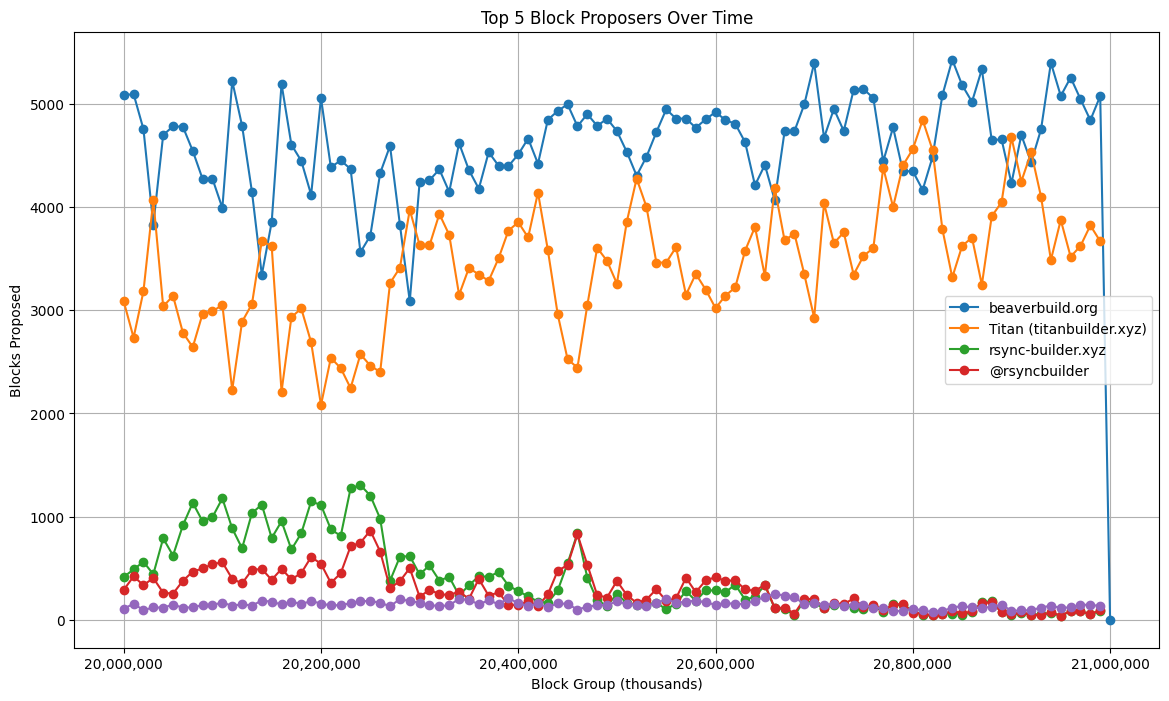

In [10]:
from sqlalchemy import text
import pandas as pd
import matplotlib.pyplot as plt

# Get blocks in 1000 block intervals
query = text("""
    WITH blocks AS (
        SELECT 
            author,
            extra_data_string,
            intDiv(block_number, :resolution) * :resolution as block_group
        FROM default.canonical_execution_block FINAL
        WHERE block_number BETWEEN :start_block AND :end_block
    ),
    top_proposers AS (
        SELECT 
            author,
            extra_data_string,
            count(*) as blocks_proposed
        FROM blocks
        GROUP BY author, extra_data_string
        ORDER BY blocks_proposed DESC
        LIMIT 5
    )
    SELECT
        b.block_group,
        b.author,
        b.extra_data_string,
        count(*) as blocks_in_period
    FROM blocks b
    INNER JOIN top_proposers t ON b.author = t.author AND b.extra_data_string = t.extra_data_string
    GROUP BY b.block_group, b.author, b.extra_data_string
    ORDER BY b.block_group, blocks_in_period DESC
""")

result = connection.execute(query, {"start_block": start_block, "end_block": end_block, "resolution": resolution})

# Convert to pandas DataFrame
df = pd.DataFrame(result.fetchall(), columns=['block_group', 'author', 'extra_data', 'blocks'])

# Create line plot
plt.figure(figsize=(14,8))
for extra_data in df['extra_data'].unique():
    extra_data_blocks = df[df['extra_data'] == extra_data]
    plt.plot(extra_data_blocks['block_group'], extra_data_blocks['blocks'], marker='o', label=extra_data)

plt.xlabel('Block Group (thousands)')
plt.ylabel('Blocks Proposed')
plt.title('Top 5 Block Proposers Over Time')
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()



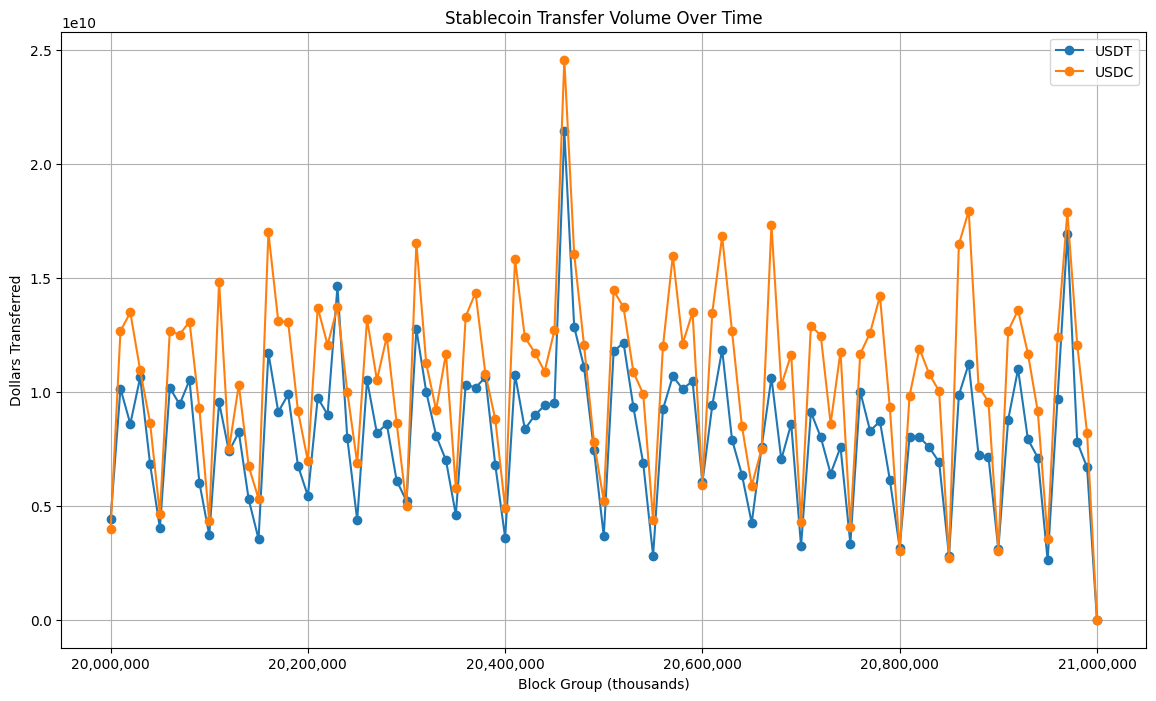

In [11]:
from sqlalchemy import text
import pandas as pd
import matplotlib.pyplot as plt

# Get stablecoin transfers in 1000 block intervals
query = text("""
    WITH blocks AS (
        SELECT
            intDiv(block_number, :resolution) * :resolution as block_group,
            erc20,
            CASE 
                WHEN erc20 = lower('0xdAC17F958D2ee523a2206206994597C13D831ec7') THEN sum(reinterpretAsUInt256(value)) / 1000000 -- USDT
                WHEN erc20 = lower('0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48') THEN sum(reinterpretAsUInt256(value)) / 1000000 -- USDC
            END as value
        FROM default.canonical_execution_erc20_transfers FINAL
        WHERE 
            block_number BETWEEN :start_block AND :end_block
            AND erc20 IN (
                lower('0xdAC17F958D2ee523a2206206994597C13D831ec7'), -- USDT
                lower('0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48')  -- USDC
            )
        GROUP BY block_group, erc20
        ORDER BY block_group
    )
    SELECT
        block_group,
        max(CASE WHEN erc20 = lower('0xdAC17F958D2ee523a2206206994597C13D831ec7') THEN value END) as USDT,
        max(CASE WHEN erc20 = lower('0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48') THEN value END) as USDC
    FROM blocks
    GROUP BY block_group
    ORDER BY block_group
""")

result = connection.execute(query, {"start_block": start_block, "end_block": end_block, "resolution": resolution})

# Convert to pandas DataFrame
df = pd.DataFrame(result.fetchall(), columns=['block_group', 'USDT', 'USDC'])

# Create line plot
plt.figure(figsize=(14,8))
plt.plot(df['block_group'], df['USDT'], marker='o', label='USDT')
plt.plot(df['block_group'], df['USDC'], marker='o', label='USDC')

plt.xlabel('Block Group (thousands)')
plt.ylabel('Dollars Transferred')
plt.title('Stablecoin Transfer Volume Over Time')
plt.legend()
plt.grid(True)

plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.show()


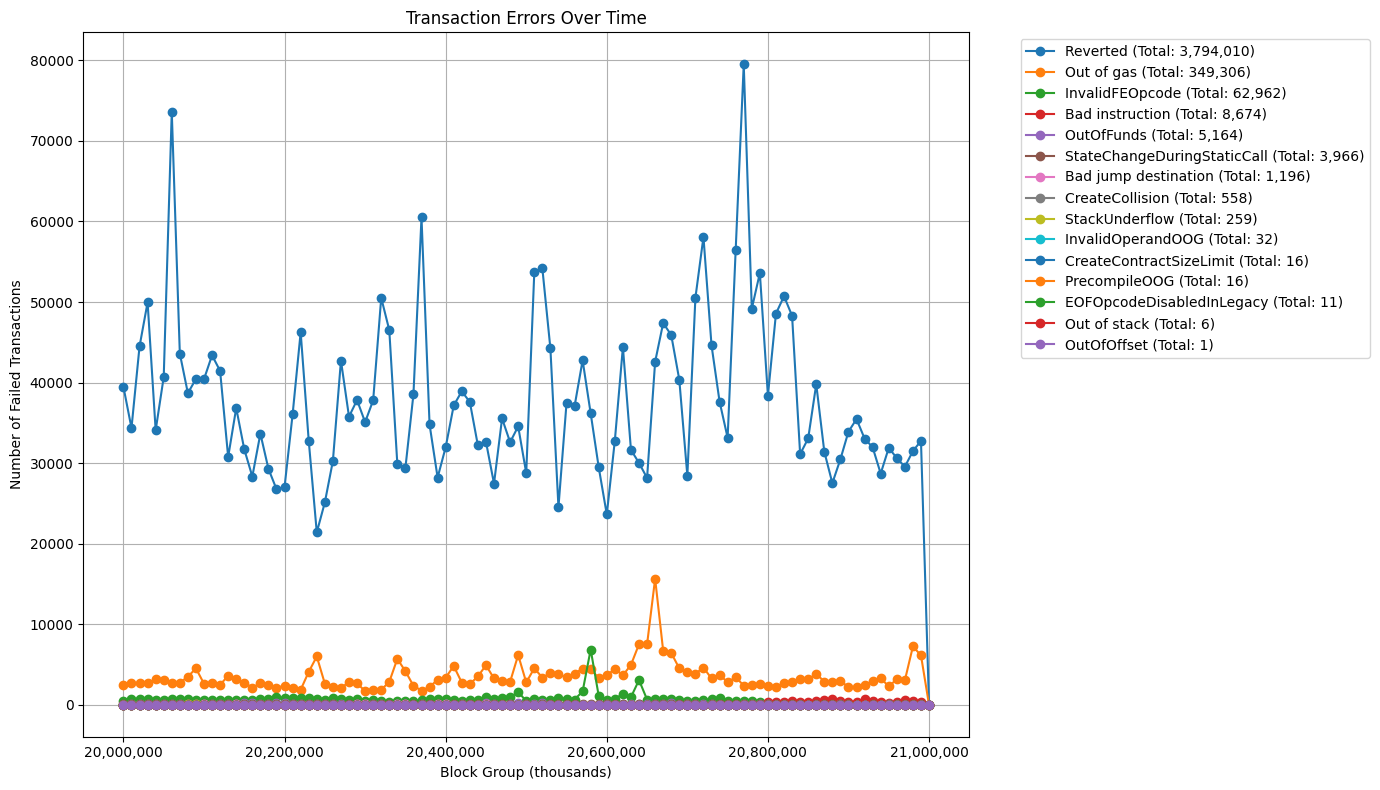


Total Error Counts:
                             error_count
error                                   
Reverted                         3794010
Out of gas                        349306
InvalidFEOpcode                    62962
Bad instruction                     8674
OutOfFunds                          5164
StateChangeDuringStaticCall         3966
Bad jump destination                1196
CreateCollision                      558
StackUnderflow                       259
InvalidOperandOOG                     32
CreateContractSizeLimit               16
PrecompileOOG                         16
EOFOpcodeDisabledInLegacy             11
Out of stack                           6
OutOfOffset                            1


In [12]:
from sqlalchemy import text
import pandas as pd
import matplotlib.pyplot as plt

# Get errored transactions grouped by error type in 1000 block intervals
query = text("""
    WITH blocks AS (
        SELECT
            intDiv(block_number, :resolution) * :resolution as block_group,
            error,
            count(DISTINCT transaction_hash) as error_count
        FROM default.canonical_execution_traces FINAL
        WHERE 
            block_number BETWEEN :start_block AND :end_block
            AND error IS NOT NULL
        GROUP BY block_group, error
        ORDER BY block_group
    )
    SELECT
        block_group,
        error,
        error_count
    FROM blocks
    ORDER BY block_group
""")

result = connection.execute(query, {"start_block": start_block, "end_block": end_block, "resolution": resolution})

# Convert to pandas DataFrame
df = pd.DataFrame(result.fetchall(), columns=['block_group', 'error', 'error_count'])

# Calculate totals for each error type
error_totals = df.groupby('error')['error_count'].sum().sort_values(ascending=False)

# Pivot the data to get errors as columns
df_pivot = df.pivot(index='block_group', columns='error', values='error_count').fillna(0)

# Reorder columns based on total occurrences
df_pivot = df_pivot[error_totals.index]

# Create line plot
plt.figure(figsize=(14,8))
for error_type in df_pivot.columns:
    total = error_totals[error_type]
    plt.plot(df_pivot.index, df_pivot[error_type], marker='o', 
             label=f'{error_type} (Total: {total:,})')

plt.xlabel('Block Group (thousands)')
plt.ylabel('Number of Failed Transactions')
plt.title('Transaction Errors Over Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# Adjust layout to prevent legend cutoff
plt.tight_layout()
plt.show()

# Display total error counts
print("\nTotal Error Counts:")
print(error_totals.to_frame().to_string())
